In [1]:
# This chapter requires importing the following packages:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage
import scipy.stats
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.features

In [2]:
# It also relies on the ffg data files:
nz = gpd.read_file('data/nz.gpkg')
nz_height = gpd.read_file('data/nz_height.gpkg')
world = gpd.read_file('data/world.gpkg')
cycle_hire = gpd.read_file('data/cycle_hire.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')
src_elev = rasterio.open('output/elev.tif')
src_landsat = rasterio.open('data/landsat.tif')
src_grain = rasterio.open('output/grain.tif')

####  This chapter shows how spatial objects can be modified in a multitude of ways based on their location and shape. 
Many spatial operations have a non-spatial (attribute) equivalent, so concepts such as subsetting and joining datasets demonstrated in the previous chapter are applicable here. 

#### Spatial operations on vector data
This section provides an overview of spatial operations on vector geographic data represented as Simple Features using the shapely and geopandas packages. This section also presents spatial operations on raster datasets using rasterio and scipy packages

In [3]:
# Spatial subsetting - process of taking a spatial object and returning a new object that relate in space to
# another object. Analogous to attribute subsetting, subsets of GeoDataFrames can be created with square bracket []
# To demonstrate spatial subsetting, we will use the nz and nz_height layers, which contain geographic data on 
# the 16 main regions and 101 highest points in New Zealand, respectively
# The ffg expression creates a new object representing only one region - Cantenbury
canterbury = nz[nz['Name'] == 'Canterbury']
canterbury

,Name,Island,Land_area,Population,Median_income,Sex_ratio,geometry
10,Canterbury,South,44504.499091,612000.0,30100,0.975327,"MULTIPOLYGON (((1686901.914 5353232.66, 167999..."


In [4]:
# Then we use the .intersects method to evaluate, for each of the nz_height points, whether they intersect with Canterbury. 
sel = nz_height.intersects(canterbury.geometry.iloc[0])
sel    # Series with 'answers'

0      False
1      False
2      False
3      False
4       True
       ...  
96     False
97     False
98     False
99     False
100    False
Length: 101, dtype: bool

In [5]:
# Finally, we can subset nz_height using the obtained Series, resulting in the subset canterbury_height 
# with only those points that intersect with Canterbury.
canterbury_height = nz_height[sel]
canterbury_height

,t50_fid,elevation,geometry
4,2362630,2749,POINT (1378169.6 5158491.453)
5,2362814,2822,POINT (1389460.041 5168749.086)
6,2362817,2778,POINT (1390166.225 5169466.158)
7,2363991,3004,POINT (1372357.036 5172728.743)
8,2363993,3114,POINT (1372062.487 5173236.285)
...,...,...,...
90,2365400,2723,POINT (1436552.349 5197470.702)
91,2365454,2706,POINT (1438695.851 5200244.307)
92,2380298,2877,POINT (1652788.127 5348984.469)
93,2380300,2711,POINT (1654213.379 5349962.973)


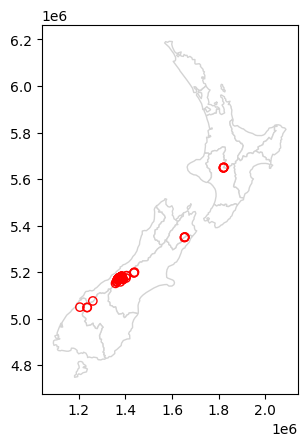

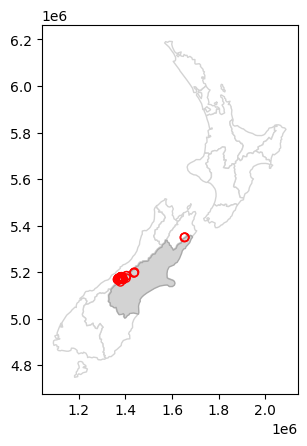

In [6]:
# Original
base = nz.plot(color='white', edgecolor='lightgrey')
nz_height.plot(ax=base, color='None', edgecolor='red');

# Subset (intersects)
base = nz.plot(color='white', edgecolor='lightgrey')
canterbury.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
canterbury_height.plot(ax=base, color='None', edgecolor='red');

In [7]:
# As an example of another method, we can use the .disjoint method to obtain all points that do not intersect with Canterbury
sel = nz_height.disjoint(canterbury.geometry.iloc[0])
canterbury_height2 = nz_height[sel]

<Axes: >

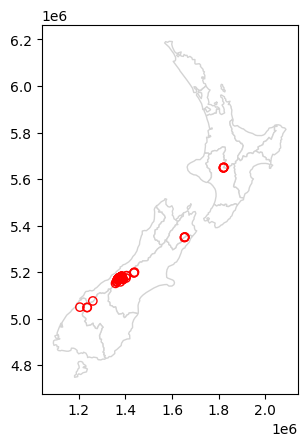

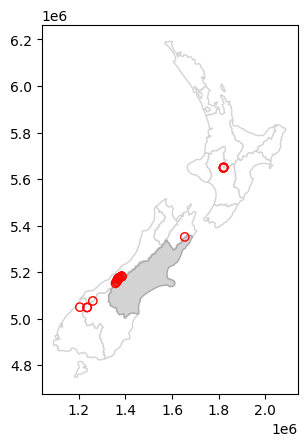

In [8]:
# Create plots that compares the original nz_height layer with the subset canterbury_height2
# Original
base = nz.plot(color='white', edgecolor='lightgrey')
nz_height.plot(ax=base, color='None', edgecolor='red')

# Subset (disjoint)
base = nz.plot(color='white', edgecolor='lightgrey')
canterbury.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
canterbury_height2.plot(ax=base, color='None', edgecolor='red')

In [9]:
# In case we need to subset according to several geometries at once - e.g., find out which points intersects
# with both Cantenbury n Southland, we can dissolve the filtering subset using .union_all
# before applying the .intersects (or any other) operator
# Here is how we can subset the nz_height points which intersect with Cantenbury/Southland
canterbury_southland = nz[nz['Name'].isin(['Canterbury', 'Southland'])]
sel = nz_height.intersects(canterbury_southland.union_all())
canterbury_southland_height = nz_height[sel]
canterbury_southland_height

,t50_fid,elevation,geometry
0,2353944,2723,POINT (1204142.603 5049971.287)
4,2362630,2749,POINT (1378169.6 5158491.453)
5,2362814,2822,POINT (1389460.041 5168749.086)
6,2362817,2778,POINT (1390166.225 5169466.158)
7,2363991,3004,POINT (1372357.036 5172728.743)
...,...,...,...
90,2365400,2723,POINT (1436552.349 5197470.702)
91,2365454,2706,POINT (1438695.851 5200244.307)
92,2380298,2877,POINT (1652788.127 5348984.469)
93,2380300,2711,POINT (1654213.379 5349962.973)


In [10]:
gpd.__version__

'1.0.1'

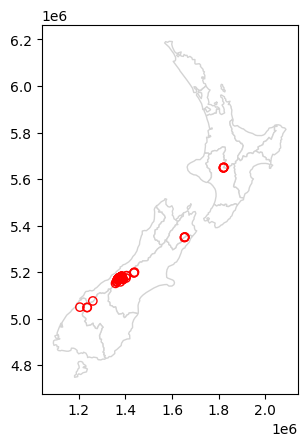

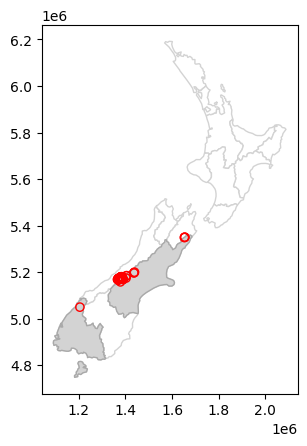

In [11]:
# Original
base = nz.plot(color='white', edgecolor='lightgrey')
nz_height.plot(ax=base, color='None', edgecolor='red');
# Subset by intersection with two polygons
base = nz.plot(color='white', edgecolor='lightgrey')
canterbury_southland.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
canterbury_southland_height.plot(ax=base, color='None', edgecolor='red');

#### Topological relations

In [12]:
points = gpd.GeoSeries([
  shapely.Point(0.2,0.1), 
  shapely.Point(0.7,0.2), 
  shapely.Point(0.4,0.8)
])
line = gpd.GeoSeries([
  shapely.LineString([(0.4,0.2), (1,0.5)])
])
poly = gpd.GeoSeries([
  shapely.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)])
])

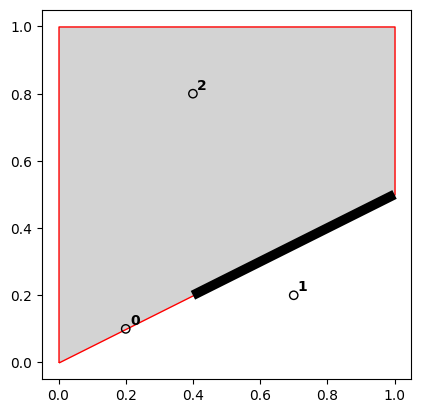

In [16]:
# To visualize the above objects::
base = poly.plot(color='lightgrey', edgecolor='red')
line.plot(ax=base, color='black', linewidth=7)
points.plot(ax=base, color='none', edgecolor='black')
for i in enumerate(points):
    base.annotate(
        i[0], xy=(i[1].x, i[1].y), 
        xytext=(3, 3), textcoords='offset points', weight='bold'
    )

In [15]:
# which of the points in points intersect in some way with polygon poly?
points.intersects(poly.iloc[0])

0     True
1    False
2     True
dtype: bool

In [17]:
# Many-to-many evaluation i.e., obtaining a matrix of all pairwise combinations of geometries from 2 GeoSeries objects
# the .apply method (package pandas) can be used to repeat a “many-to-one” evaluation over all geometries in the second layer, 
# resulting in a matrix of pairwise results.
# We'll create another GeoSeries with two polygons named poly2 to demonstrate this:
poly2 = gpd.GeoSeries([
  shapely.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)]),
  shapely.Polygon([(0,0), (1,0.5), (1,0), (0,0)])
])

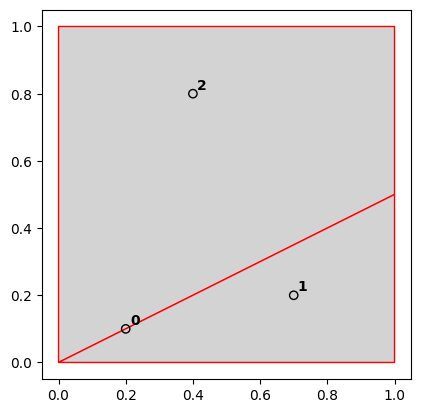

In [18]:
# Our two input objects are illustrated in the below figure:
base = poly2.plot(color='lightgrey', edgecolor='red')
points.plot(ax=base, color='none', edgecolor='black')
for i in enumerate(points):
    base.annotate(
        i[0], xy=(i[1].x, i[1].y), 
        xytext=(3, 3), textcoords='offset points', weight='bold'
    )

In [19]:
# Now we can use the .apply method to get the intersection relations matrix
points.apply(lambda x: poly2.intersects(x))

,0,1
0,True,True
1,False,True
2,True,False


In [20]:
# More restrictive questions include which points lie within the polygon, 
# and which features are on or contain a shared boundary with it?
points.within(poly.iloc[0])

0    False
1    False
2     True
dtype: bool

In [21]:
points.touches(poly.iloc[0])

0     True
1    False
2    False
dtype: bool

In [22]:
# The opposite of .intersects is disjoints which returns only objects that do not spatially relate 
# in any way to the selecting object
points.disjoint(poly.iloc[0])

0    False
1     True
2    False
dtype: bool

In [23]:
points.distance(poly.iloc[0]) < 0.2

0    True
1    True
2    True
dtype: bool

#### Spatial Joining
- adds new columns to the target object (the argument x in joining functions), from a source object (y).

In [24]:
# Imagine you have ten points randomly distributed across the Earth’s surface and you ask, 
# for the points that are on land, which countries are they in?
# The starting point is to create points that are randomly scattered over the planar surface that represents 
# Earth's geographic coordinates in decimal degrees

In [25]:
np.random.seed(11)       ## set seed for reproducibility
bb = world.total_bounds  ## the world's bounds
x = np.random.uniform(low=bb[0], high=bb[2], size=10)
y = np.random.uniform(low=bb[1], high=bb[3], size=10)
random_points = gpd.points_from_xy(x, y, crs=4326)
random_points = gpd.GeoDataFrame({'geometry': random_points})
random_points

,geometry
0,POINT (-115.10291 36.78178)
1,POINT (-172.98891 -71.02938)
2,POINT (-13.24134 65.23272)
3,POINT (80.97621 58.85495)
4,POINT (-28.72671 -61.25002)
5,POINT (-5.24625 19.83849)
6,POINT (-175.39891 -86.34517)
7,POINT (-4.54623 -69.64082)
8,POINT (159.05039 -34.99599)
9,POINT (126.28622 -62.49509)


In [26]:
# Before creating the joined dataset, we use spatial subsetting to create an object 
# which contains only countries that contain random points
world_random = world[world.intersects(random_points.union_all())]
world_random

,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap,geometry
4,US,United States,North America,Americas,Northern America,Country,9.510744e+06,318622525.0,78.841463,51921.984639,"MULTIPOLYGON (((-171.73166 63.78252, -171.7911..."
18,RU,Russian Federation,Europe,Europe,Eastern Europe,Sovereign country,1.701851e+07,143819666.0,70.743659,25284.586202,"MULTIPOLYGON (((-180 64.97971, -179.43268 65.4..."
52,ML,Mali,Africa,Africa,Western Africa,Sovereign country,1.235561e+06,16962846.0,57.007000,1865.160622,"MULTIPOLYGON (((-11.51394 12.44299, -11.45617 ..."
159,AQ,Antarctica,Antarctica,Antarctica,Antarctica,Indeterminate,1.233596e+07,NaN,NaN,NaN,"MULTIPOLYGON (((-180 -89.9, 179.99999 -89.9, 1..."


In [27]:
random_points

,geometry
0,POINT (-115.10291 36.78178)
1,POINT (-172.98891 -71.02938)
2,POINT (-13.24134 65.23272)
3,POINT (80.97621 58.85495)
4,POINT (-28.72671 -61.25002)
5,POINT (-5.24625 19.83849)
6,POINT (-175.39891 -86.34517)
7,POINT (-4.54623 -69.64082)
8,POINT (159.05039 -34.99599)
9,POINT (126.28622 -62.49509)


In [28]:
# Spatial joins are implemented with x.sjoin(y) 
random_joined = random_points.sjoin(world, how="left")
random_joined

,geometry,index_right,iso_a2,name_long,continent,region_un,subregion,type,area_km2,pop,lifeExp,gdpPercap
0,POINT (-115.10291 36.78178),4.0,US,United States,North America,Americas,Northern America,Country,9.510744e+06,318622525.0,78.841463,51921.984639
1,POINT (-172.98891 -71.02938),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-13.24134 65.23272),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (80.97621 58.85495),18.0,RU,Russian Federation,Europe,Europe,Eastern Europe,Sovereign country,1.701851e+07,143819666.0,70.743659,25284.586202
4,POINT (-28.72671 -61.25002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,POINT (-5.24625 19.83849),52.0,ML,Mali,Africa,Africa,Western Africa,Sovereign country,1.235561e+06,16962846.0,57.007000,1865.160622
6,POINT (-175.39891 -86.34517),159.0,AQ,Antarctica,Antarctica,Antarctica,Antarctica,Indeterminate,1.233596e+07,NaN,NaN,NaN
7,POINT (-4.54623 -69.64082),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,POINT (159.05039 -34.99599),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POINT (126.28622 -62.49509),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


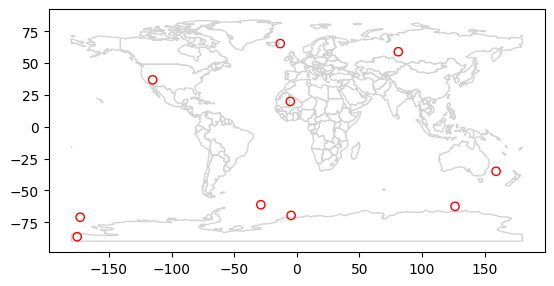

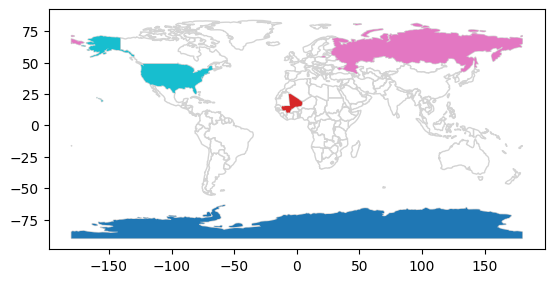

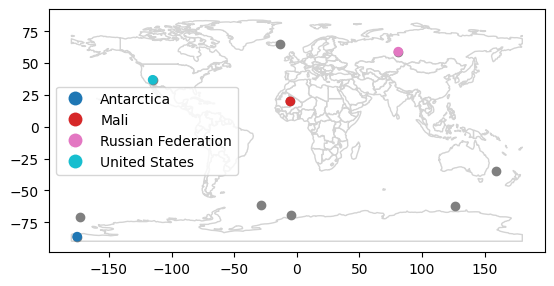

In [29]:
# Random points
base = world.plot(color='white', edgecolor='lightgrey')
random_points.plot(ax=base, color='None', edgecolor='red');
# World countries intersecting with the points
base = world.plot(color='white', edgecolor='lightgrey')
world_random.plot(ax=base, column='name_long');
# Points with joined country names
base = world.plot(color='white', edgecolor='lightgrey')
random_joined.geometry.plot(ax=base, color='grey')
random_joined.plot(ax=base, column='name_long', legend=True);

#### Non-overlapping joins
Sometimes two geographic datasets do not touch but they have a strong geographic relationship

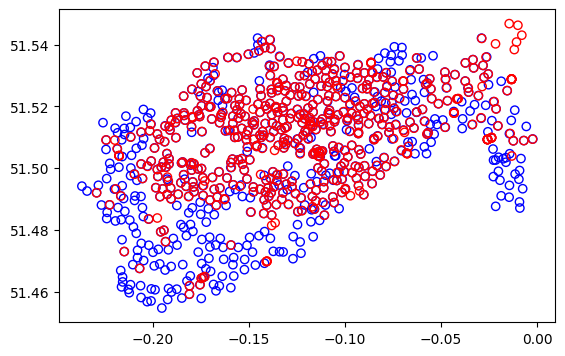

In [30]:
# The datasets cycle_hire and cycle_hire_osm provide a good example
# Plotting them reveals that they're often closely related but they do not seem to touch
base = cycle_hire.plot(edgecolor='blue', color='none')        # official data
cycle_hire_osm.plot(ax=base, edgecolor='red', color='none');    # open street map data

In [31]:
# We can check if any of the points are the same by creating a pairwise boolean matrix of 
# .intersects relations, then evaluating whether any of the values in it is True
m = cycle_hire.geometry.apply(
    lambda x: cycle_hire_osm.geometry.intersects(x)
)

# Interested in whether any of the values in the ndarray is True
m.to_numpy().any()

np.False_

In [32]:
# Imagine that we want to join the capacity variable in cycle_hire_osm to cycle_hire
# This is when a non-overlapping join is needed. Spatial join along with buffered geometries can be used to do that
crs = 27700
cycle_hire_buffers = cycle_hire.copy().to_crs(crs)
cycle_hire_buffers.geometry = cycle_hire_buffers.buffer(20)
cycle_hire_buffers = gpd.sjoin(
    cycle_hire_buffers, 
    cycle_hire_osm.to_crs(crs),
    how='left'
)
cycle_hire_buffers

,id,name_left,area,nbikes,nempty,geometry,index_right,osm_id,name_right,capacity,cyclestreets_id,description
0,1,River Street,Clerkenwell,4,14,"POLYGON ((531223.517 182832.066, 531223.421 18...",232.0,869697014,River Street,9.0,None,None
1,2,Phillimore Gardens,Kensington,2,34,"POLYGON ((525228.067 179391.922, 525227.97 179...",277.0,885331201,"Kensington, Phillimore Gardens",27.0,None,None
2,3,Christopher Street,Liverpool Street,0,32,"POLYGON ((533005.807 182001.572, 533005.711 18...",293.0,920087626,Christopher Street,NaN,None,None
3,4,St. Chad's Street,King's Cross,4,19,"POLYGON ((530457.757 182912.038, 530457.661 18...",4.0,781506147,None,NaN,None,None
4,5,Sedding Street,Sloane Square,15,12,"POLYGON ((528070.966 178742.004, 528070.87 178...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
737,773,Tallis Street,Temple,0,23,"POLYGON ((531455.032 180916.01, 531454.935 180...",504.0,4387228849,"Tallis Street, Temple",14.0,None,None
738,774,Hurlingham Park,Parsons Green,11,9,"POLYGON ((524818.028 176102.023, 524817.932 17...",NaN,NaN,NaN,NaN,NaN,NaN
739,775,Little Brook Green,Brook Green,16,17,"POLYGON ((523411.016 179020.043, 523410.92 179...",NaN,NaN,NaN,NaN,NaN,NaN
740,776,Abyssinia Close,Clapham Junction,10,10,"POLYGON ((527457.473 175077.168, 527457.377 17...",NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Note that the number of rows in the joined result is greater than the target.
# This is because some cycle_hire_buffers have multiple matches in cycle_hire_osm
# To aggregate the values for the overlapping points and return the mean
cycle_hire_buffers = cycle_hire_buffers[['id', 'capacity', 'geometry']] \
    .dissolve(by='id', aggfunc='mean') \
    .reset_index()
cycle_hire_buffers.geometry = cycle_hire_buffers.centroid
cycle_hire_buffers

,id,geometry,capacity
0,1,POINT (531203.517 182832.066),9.0
1,2,POINT (525208.067 179391.922),27.0
2,3,POINT (532985.807 182001.572),NaN
3,4,POINT (530437.757 182912.038),NaN
4,5,POINT (528050.966 178742.004),NaN
...,...,...,...
737,773,POINT (531435.032 180916.01),14.0
738,774,POINT (524798.028 176102.023),NaN
739,775,POINT (523391.016 179020.043),NaN
740,776,POINT (527437.473 175077.168),NaN


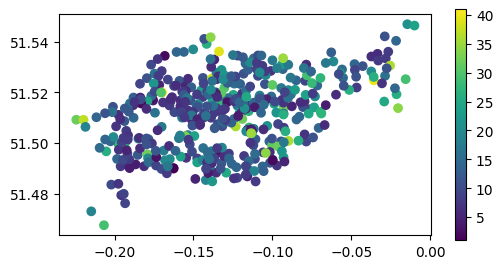

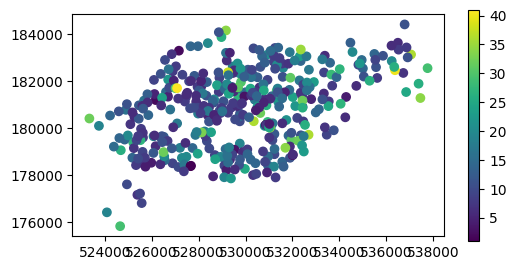

In [34]:
# Input
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cycle_hire_osm.plot(column='capacity', legend=True, ax=ax);
# Join result
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cycle_hire_buffers.plot(column='capacity', legend=True, ax=ax);

#### Spatial aggregation
This section shows how grouping by spatial objects can be achieved using spatial joins combined with non-spatial aggregation.

In [35]:
# Imagine you want to find out the avg height of nz_height points in each region
# It is the geometry of the source(nz) that determines how values in the target(nz_height) are grouped
# This can be done in 3 steps:

#1. Figuring out which nz region each nz_height point falls in-using gpd.sjoin
nz_height2 = gpd.sjoin(
  nz_height[['elevation', 'geometry']], 
  nz[['Name', 'geometry']], 
  how='left'
)
nz_height2

,elevation,geometry,index_right,Name
0,2723,POINT (1204142.603 5049971.287),12,Southland
1,2820,POINT (1234725.325 5048309.302),11,Otago
2,2830,POINT (1235914.511 5048745.117),11,Otago
3,3033,POINT (1259701.635 5076570.049),9,West Coast
4,2749,POINT (1378169.6 5158491.453),10,Canterbury
...,...,...,...,...
96,2797,POINT (1821014.19 5647970.666),7,Manawatu-Wanganui
97,2757,POINT (1820642.909 5648331.194),7,Manawatu-Wanganui
98,2751,POINT (1820659.873 5649488.235),2,Waikato
99,2720,POINT (1822262.592 5650428.656),2,Waikato


In [36]:
# Second, we calculate the avg elevation using ordinary (non-spatial) aggregation. 
# This result tells us the avg elevation of all nz_height points located within each nz region
nz_height2 = nz_height2.groupby('Name')[['elevation']].mean().reset_index()
nz_height2

,Name,elevation
0,Canterbury,2994.600000
1,Manawatu-Wanganui,2777.000000
2,Marlborough,2720.000000
3,Otago,2825.000000
4,Southland,2723.000000
5,Waikato,2734.333333
6,West Coast,2889.454545


In [37]:
# The third n final step is joining the averages back to the nz layer:
nz2 = pd.merge(nz[['Name', 'geometry']], nz_height2, on='Name', how='left')
nz2

,Name,geometry,elevation
0,Northland,"MULTIPOLYGON (((1745493.196 6001802.169, 17405...",NaN
1,Auckland,"MULTIPOLYGON (((1803822.103 5900006.143, 17914...",NaN
2,Waikato,"MULTIPOLYGON (((1860345.005 5859664.761, 18578...",2734.333333
3,Bay of Plenty,"MULTIPOLYGON (((2049387.29 5832785.434, 205101...",NaN
4,Gisborne,"MULTIPOLYGON (((2024489.357 5674919.854, 20190...",NaN
5,Hawke's Bay,"MULTIPOLYGON (((2024489.357 5674919.854, 20241...",NaN
6,Taranaki,"MULTIPOLYGON (((1740438.216 5714538.134, 17438...",NaN
7,Manawatu-Wanganui,"MULTIPOLYGON (((1866732.458 5664323.109, 18689...",2777.000000
8,Wellington,"MULTIPOLYGON (((1881590.326 5489434.391, 18756...",NaN
9,West Coast,"MULTIPOLYGON (((1557042.169 5319333.386, 15542...",2889.454545


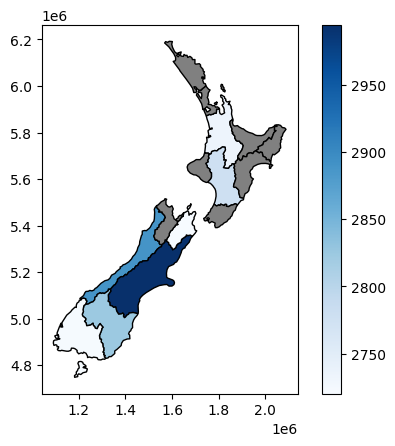

In [38]:
# Note that the missing_kwds part determines the style of geometries where the symbology attribute 
# (elevation) is missing, because there were no nz_height points overlapping with them. 
# The default is to omit them which is usually not what we want but here they're shown in black outline n grey fill

# Average height of the top 101 high points across the region of New Zealand
nz2.plot(
  column='elevation', 
  legend=True,
  cmap='Blues', edgecolor='black',
  missing_kwds={'color': 'grey', 'edgecolor': 'black'}
);

#### Joining incongruent layers

In [39]:
# To demonstrate joining incongruent layers, we'll create a "synthetic" layer comprising a regular grid of rectangles of 
# size 100 x 100km covering the extent of the nz layer
# This recipe can be used to create a regular grid covering any given layer (other than nz), at the specified resolution (res)

# Settings: grid extent, resolution, and CRS
bounds = nz.total_bounds
crs = nz.crs
res = 100000
# Calculating grid dimensions
xmin, ymin, xmax, ymax = bounds
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax+res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax+res)), res))
rows.reverse()
# For each cell, create 'shapely' polygon (rectangle)
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)])
        )
# To 'GeoDataFrame'
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
# Remove rows/columns beyond the extent
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]
# Add consecultive IDs
grid['id'] = grid.index
grid

,geometry,id
0,"POLYGON ((1090143 6248536, 1190143 6248536, 11...",0
1,"POLYGON ((1090143 6148536, 1190143 6148536, 11...",1
2,"POLYGON ((1090143 6048536, 1190143 6048536, 11...",2
3,"POLYGON ((1090143 5948536, 1190143 5948536, 11...",3
4,"POLYGON ((1090143 5848536, 1190143 5848536, 11...",4
...,...,...
154,"POLYGON ((1990143 5248536, 2090143 5248536, 20...",154
155,"POLYGON ((1990143 5148536, 2090143 5148536, 20...",155
156,"POLYGON ((1990143 5048536, 2090143 5048536, 20...",156
157,"POLYGON ((1990143 4948536, 2090143 4948536, 20...",157


<Axes: >

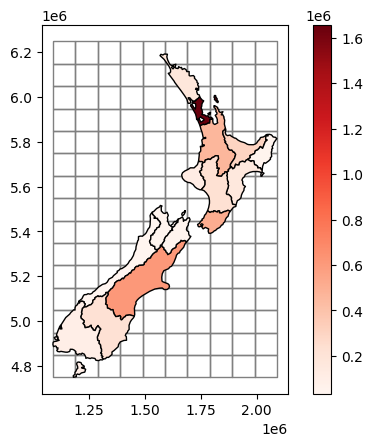

In [40]:
# To visualize the grid layer along with the nz layer:
base = grid.plot(color='none', edgecolor='grey')
nz.plot(
    ax=base, 
    column='Population',
    edgecolor='black', 
    legend=True, 
    cmap='Reds'
)

In [41]:
# Our goal is now to transfer the 'Population' attribute to the rectangular grid polygons which is an example of a join
# between incongruent layers.  To do that, we basically need to calculate–for each grid cell—the weighted sum of the 
# population in nz polygons coinciding with that cell.
nz['area'] = nz.area
nz

,Name,Island,Land_area,Population,Median_income,Sex_ratio,geometry,area
0,Northland,North,12500.561149,175500.0,23400,0.942453,"MULTIPOLYGON (((1745493.196 6001802.169, 17405...",1.289058e+10
1,Auckland,North,4941.572557,1657200.0,29600,0.944286,"MULTIPOLYGON (((1803822.103 5900006.143, 17914...",4.911565e+09
2,Waikato,North,23900.036383,460100.0,27900,0.952050,"MULTIPOLYGON (((1860345.005 5859664.761, 18578...",2.458882e+10
3,Bay of Plenty,North,12071.144689,299900.0,26200,0.928039,"MULTIPOLYGON (((2049387.29 5832785.434, 205101...",1.227102e+10
4,Gisborne,North,8385.826619,48500.0,24400,0.934973,"MULTIPOLYGON (((2024489.357 5674919.854, 20190...",8.364554e+09
5,Hawke's Bay,North,14137.524441,164000.0,26100,0.923838,"MULTIPOLYGON (((2024489.357 5674919.854, 20241...",1.424252e+10
6,Taranaki,North,7254.480433,118000.0,29100,0.956936,"MULTIPOLYGON (((1740438.216 5714538.134, 17438...",7.313991e+09
7,Manawatu-Wanganui,North,22220.608387,234500.0,25000,0.938773,"MULTIPOLYGON (((1866732.458 5664323.109, 18689...",2.223904e+10
8,Wellington,North,8048.552772,513900.0,32700,0.933552,"MULTIPOLYGON (((1881590.326 5489434.391, 18756...",8.149896e+09
9,West Coast,South,23245.455880,32400.0,26900,1.013907,"MULTIPOLYGON (((1557042.169 5319333.386, 15542...",2.340935e+10


In [42]:
# Next we use the .overlay method to calculate the pairwise intersections btw nz and grid
# As a result we now have a layer where each nz polygon is split according to the grid polygons hereby named nz_grid
nz_grid = nz.overlay(grid)
nz_grid = nz_grid[['id', 'area', 'Population', 'geometry']]
nz_grid

,id,area,Population,geometry
0,64,1.289058e+10,175500.0,"POLYGON ((1586362.965 6168009.001, 1568216.708..."
1,80,1.289058e+10,175500.0,"POLYGON ((1590143 6162776.641, 1590143 6191701..."
2,81,1.289058e+10,175500.0,"POLYGON ((1633099.964 6066188.094, 1632333.259..."
3,82,1.289058e+10,175500.0,"POLYGON ((1688395.37 5989681.201, 1677965.696 ..."
4,97,1.289058e+10,175500.0,"POLYGON ((1698281.254 6113546.125, 1698221.399..."
...,...,...,...,...
105,87,1.046485e+10,46200.0,"MULTIPOLYGON (((1649908.695 5455398.241, 16565..."
106,88,1.046485e+10,46200.0,"POLYGON ((1679241.14 5359477.533, 1667754.211 ..."
107,89,1.046485e+10,46200.0,"POLYGON ((1641283.955 5341361.167, 1638347.722..."
108,103,1.046485e+10,46200.0,"POLYGON ((1690724.332 5458875.452, 1698889.134..."


<Axes: >

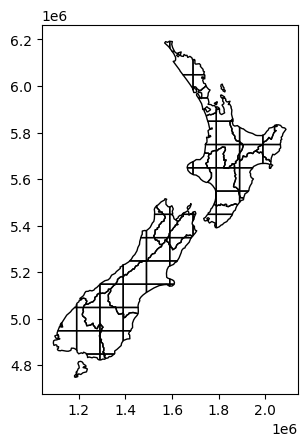

In [43]:
nz_grid.plot(color='none', edgecolor='black')

In [44]:
# We also need to calculate the areas of the intersections here into a new attribute 'area_sub'
# If an nz polygon was completely within a single grid polygon then area_sub is going to be equal to area; 
# otherwise it is going to be smaller
nz_grid['area_sub'] = nz_grid.area
nz_grid

,id,area,Population,geometry,area_sub
0,64,1.289058e+10,175500.0,"POLYGON ((1586362.965 6168009.001, 1568216.708...",3.231015e+08
1,80,1.289058e+10,175500.0,"POLYGON ((1590143 6162776.641, 1590143 6191701...",4.612641e+08
2,81,1.289058e+10,175500.0,"POLYGON ((1633099.964 6066188.094, 1632333.259...",5.685656e+09
3,82,1.289058e+10,175500.0,"POLYGON ((1688395.37 5989681.201, 1677965.696 ...",1.307476e+09
4,97,1.289058e+10,175500.0,"POLYGON ((1698281.254 6113546.125, 1698221.399...",2.013006e+09
...,...,...,...,...,...
105,87,1.046485e+10,46200.0,"MULTIPOLYGON (((1649908.695 5455398.241, 16565...",4.526248e+08
106,88,1.046485e+10,46200.0,"POLYGON ((1679241.14 5359477.533, 1667754.211 ...",7.223641e+09
107,89,1.046485e+10,46200.0,"POLYGON ((1641283.955 5341361.167, 1638347.722...",1.826943e+09
108,103,1.046485e+10,46200.0,"POLYGON ((1690724.332 5458875.452, 1698889.134...",1.227037e+08


In [45]:
# The real popn size of each nz_grid feature however is smaller/equal depending on the geographic area proportion
# that it occupies out of the original nz feature. 
# To make the “correction”, we first calculate the ratio (area_prop) and then multiply it by the population.
# 'population' now has the correct estimate of popn sizes in nz_grid:
nz_grid['area_prop'] = nz_grid['area_sub'] / nz_grid['area']
nz_grid['population'] = nz_grid['Population'] * nz_grid['area_prop']
nz_grid

,id,area,Population,geometry,area_sub,area_prop,population
0,64,1.289058e+10,175500.0,"POLYGON ((1586362.965 6168009.001, 1568216.708...",3.231015e+08,0.025065,4398.897141
1,80,1.289058e+10,175500.0,"POLYGON ((1590143 6162776.641, 1590143 6191701...",4.612641e+08,0.035783,6279.925114
2,81,1.289058e+10,175500.0,"POLYGON ((1633099.964 6066188.094, 1632333.259...",5.685656e+09,0.441071,77407.916241
3,82,1.289058e+10,175500.0,"POLYGON ((1688395.37 5989681.201, 1677965.696 ...",1.307476e+09,0.101429,17800.759095
4,97,1.289058e+10,175500.0,"POLYGON ((1698281.254 6113546.125, 1698221.399...",2.013006e+09,0.156161,27406.269178
...,...,...,...,...,...,...,...
105,87,1.046485e+10,46200.0,"MULTIPOLYGON (((1649908.695 5455398.241, 16565...",4.526248e+08,0.043252,1998.239223
106,88,1.046485e+10,46200.0,"POLYGON ((1679241.14 5359477.533, 1667754.211 ...",7.223641e+09,0.690277,31890.789070
107,89,1.046485e+10,46200.0,"POLYGON ((1641283.955 5341361.167, 1638347.722...",1.826943e+09,0.174579,8065.550415
108,103,1.046485e+10,46200.0,"POLYGON ((1690724.332 5458875.452, 1698889.134...",1.227037e+08,0.011725,541.709946


In [46]:
# What is left to be done is to sum the population in all parts forming the same grid cell and join them back to the grid layer
# Note that many of the grid cells have “No Data” for population, because they have no intersection with nz at all
nz_grid = nz_grid.groupby('id')['population'].sum().reset_index()
grid = pd.merge(grid, nz_grid[['id', 'population']], on='id', how='left')
grid

,geometry,id,population
0,"POLYGON ((1090143 6248536, 1190143 6248536, 11...",0,NaN
1,"POLYGON ((1090143 6148536, 1190143 6148536, 11...",1,NaN
2,"POLYGON ((1090143 6048536, 1190143 6048536, 11...",2,NaN
3,"POLYGON ((1090143 5948536, 1190143 5948536, 11...",3,NaN
4,"POLYGON ((1090143 5848536, 1190143 5848536, 11...",4,NaN
...,...,...,...
145,"POLYGON ((1990143 5248536, 2090143 5248536, 20...",154,NaN
146,"POLYGON ((1990143 5148536, 2090143 5148536, 20...",155,NaN
147,"POLYGON ((1990143 5048536, 2090143 5048536, 20...",156,NaN
148,"POLYGON ((1990143 4948536, 2090143 4948536, 20...",157,NaN


<Axes: >

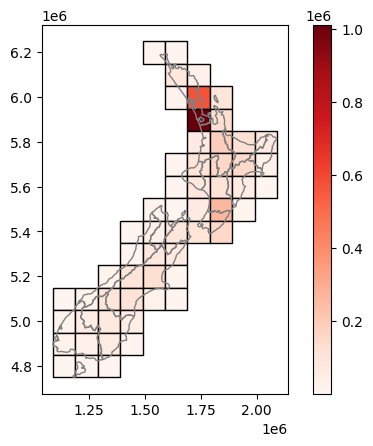

In [47]:
# Now to visualize the final result grid with the incongruently joined population attribute from nz
base = grid.plot(
    column='population', 
    edgecolor='black',
    legend=True, 
    cmap='Reds'
);

nz.plot(ax=base, color='none', edgecolor='grey', legend=True)

The procedure in this section is known as an area-weighted interpolation of a spatially extensive (e.g., population) variable. In extensive interpolation, we assume that the variable of interest represents counts (such as, here, inhabitants) uniformly distributed across space. In such case, each “part” of a given polygon captures the respective proportion of counts (such as, half of a region with N inhabitants contains N/2 ihnabitants). Accordingly, summing the parts gives the total count of the total area.

#### Distance relations

In [48]:
# To illustrate the .distance method, let's take the 3 highest point in NZ with sort_values and .iloc
nz_highest = nz_height.sort_values(by='elevation', ascending=False).iloc[:3, :]
nz_highest

,t50_fid,elevation,geometry
64,2372236,3724,POINT (1369317.63 5169132.284)
63,2372235,3717,POINT (1369512.866 5168235.616)
67,2372252,3688,POINT (1369381.942 5168761.875)


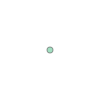

In [49]:
# Additionally we need the geographic centroid of the canterbury region
canterbury_centroid = canterbury.centroid.iloc[0]
canterbury_centroid

In [50]:
# Now we're able to calculate the distances from each of the 3 elevation points to the centroid of the Canterbury region
nz_highest.distance(canterbury_centroid)

64    115539.995747
63    115390.248038
67    115493.594066
dtype: float64

In [51]:
# To obtain a distance matrix i.e. a pairwise set of distances btw all combinations of features in object x and y
# we need to use the .apply method (analogous to the way we created the .intersect boolean matrix)
# To illustrate this, let's now take two regions in nz
sel = nz['Name'].str.contains('Canter|Otag')
co = nz[sel]
co

,Name,Island,Land_area,Population,Median_income,Sex_ratio,geometry,area
10,Canterbury,South,44504.499091,612000.0,30100,0.975327,"MULTIPOLYGON (((1686901.914 5353232.66, 167999...",4.532656e+10
11,Otago,South,31186.309188,224200.0,26300,0.951169,"MULTIPOLYGON (((1335204.789 5126878.25, 133695...",3.190356e+10


In [52]:
# A distance matrix btw each of the first 3 elevation points and the two regions is then obtained as follows:
d = nz_height.iloc[:3, :].apply(lambda x: co.distance(x.geometry), axis=1)
d

,10,11
0,123537.158269,15497.717252
1,94282.773074,0.000000
2,93018.560814,0.000000


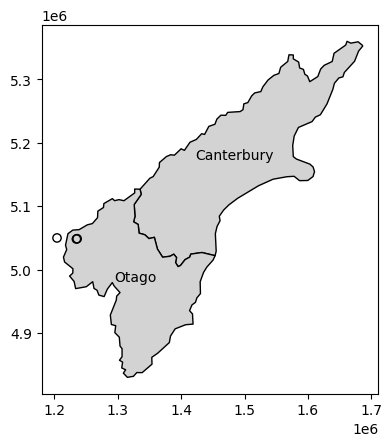

In [53]:
# Note that the distance between the second and third features in nz_height and the second feature in co is zero. 
# This demonstrates the fact that distances between points and polygons refer to the distance to any part of the polygon:
# the second n third points in nz_height are in Otago which can be verified by plotting them (two almost completely overlapping points)
fig, ax = plt.subplots()
co.plot(color='lightgrey', edgecolor='black', ax=ax)
co.apply(
    lambda x: ax.annotate(
        text=x['Name'], 
        xy=x.geometry.centroid.coords[0], 
        ha='center'
    ), 
    axis=1
)
nz_height.iloc[:3, :].plot(color='none', edgecolor='black', ax=ax);

#### Spatial operations on raster data
This section builds on the previous section to demonstrate more advanced and explicitly spatial raster operations

##### Spatial subsetting

In [54]:
# In case we want all values at once, such as when the number of points is small, we can force the generation of all values
# from a generator at once using list
list(src_elev.sample([(0.1, 0.1)]))

[array([16], dtype=uint8)]

In [55]:
# We can also extract the values of multiple points at once - Here we extract the raster values at two points
list(src_elev.sample([(0.1, 0.1), (1.1, 1.1)]))

[array([16], dtype=uint8), array([6], dtype=uint8)]

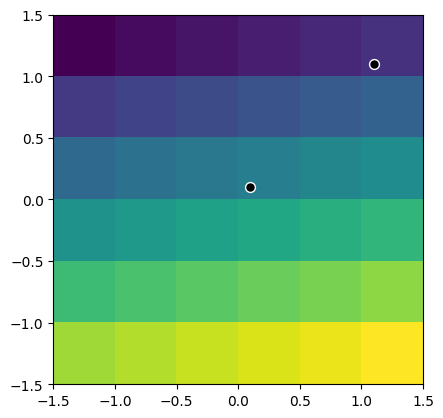

In [56]:
# The location of the two sample points on top of the elev.tif raster is illustrated below:
fig, ax = plt.subplots()
rasterio.plot.show(src_elev, ax=ax)
gpd.GeoSeries([shapely.Point(0.1, 0.1)]) \
    .plot(color='black', edgecolor='white', markersize=50, ax=ax)
gpd.GeoSeries([shapely.Point(1.1, 1.1)]) \
    .plot(color='black', edgecolor='white', markersize=50, ax=ax);

In [57]:
# Another common use case of spatial subsetting is using a boolean mask
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

In [58]:
# Create a corresponding random boolean mask of the same shape as elev.tif with values randomly assigned to True and False
np.random.seed(1)
mask = np.random.choice([True, False], src_elev.shape)
mask

array([[False, False,  True,  True, False, False],
       [False, False, False,  True,  True, False],
       [ True, False, False,  True,  True, False],
       [ True,  True,  True, False,  True,  True],
       [False,  True,  True,  True, False,  True],
       [ True,  True, False, False, False, False]])

In [59]:
# Now suppose we want to keep those values of elev which are False in mask
# In the case of elev.tif, to be able to store np.nan in the array of values we need to convert it to float
masked_elev = elev.copy()
masked_elev = masked_elev.astype('float64')
masked_elev[mask] = np.nan
masked_elev

array([[ 1.,  2., nan, nan,  5.,  6.],
       [ 7.,  8.,  9., nan, nan, 12.],
       [nan, 14., 15., nan, nan, 18.],
       [nan, nan, nan, 22., nan, nan],
       [25., nan, nan, nan, 29., nan],
       [nan, nan, 33., 34., 35., 36.]])

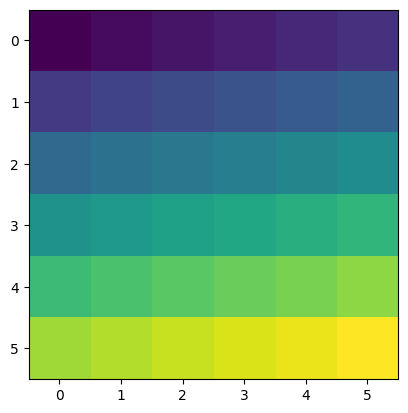

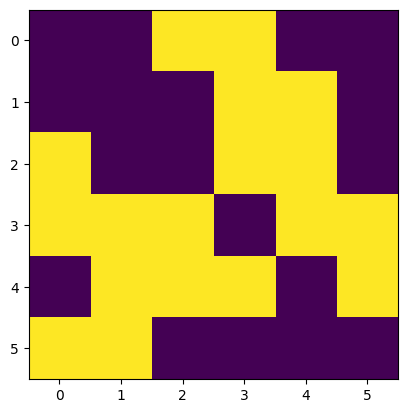

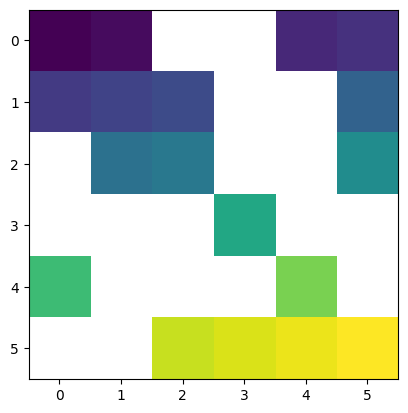

In [60]:
# Visualizing
rasterio.plot.show(elev);
rasterio.plot.show(mask);
rasterio.plot.show(masked_elev);

In [61]:
# The mask can be created from the array itself using condition(s). That way we can replace some values (eg values assumed to 
# be wrong) with np.nan such as in the ffg example:
elev2 = elev.copy()
elev2 = elev2.astype('float64')
elev2[elev2 < 20] = np.nan
elev2

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

#### Map algebra
The term map algebra is used to describe a set of conventions, capabilities, and techniques for the analysis of geographic raster 
and (although less prominently) vector data

##### Local Operations

In [62]:
# 1. Local operations comprise all cell-by-cell operations in one or several layers.
elev + elev

array([[ 2,  4,  6,  8, 10, 12],
       [14, 16, 18, 20, 22, 24],
       [26, 28, 30, 32, 34, 36],
       [38, 40, 42, 44, 46, 48],
       [50, 52, 54, 56, 58, 60],
       [62, 64, 66, 68, 70, 72]], dtype=uint8)

In [63]:
# Some functions and operators automatically change the data type to accommodate the resulting values, 
# while other operators do not, potentially resulting in overflow (i.e., incorrect values for results beyond 
# the data type range, such as trying to accomodate values above 255 in an int8 array).
# For example elev**2 results in overflow. Since the ** operator does not automatically change the data type, 
# leaving it as int8, the resulting array has incorrect values for 16**2, 17**2 which are above 255 and therefore cannot be accomodated
elev ** 2

array([[  1,   4,   9,  16,  25,  36],
       [ 49,  64,  81, 100, 121, 144],
       [169, 196, 225,   0,  33,  68],
       [105, 144, 185, 228,  17,  64],
       [113, 164, 217,  16,  73, 132],
       [193,   0,  65, 132, 201,  16]], dtype=uint8)

In [64]:
# To avoid this situation we can transform elev to the standard int64 data using .astype before applying the ** operator
elev.astype(int)**2

array([[   1,    4,    9,   16,   25,   36],
       [  49,   64,   81,  100,  121,  144],
       [ 169,  196,  225,  256,  289,  324],
       [ 361,  400,  441,  484,  529,  576],
       [ 625,  676,  729,  784,  841,  900],
       [ 961, 1024, 1089, 1156, 1225, 1296]])

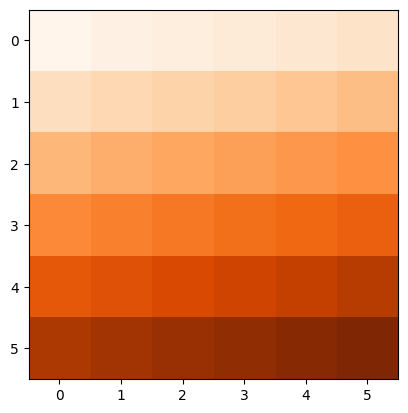

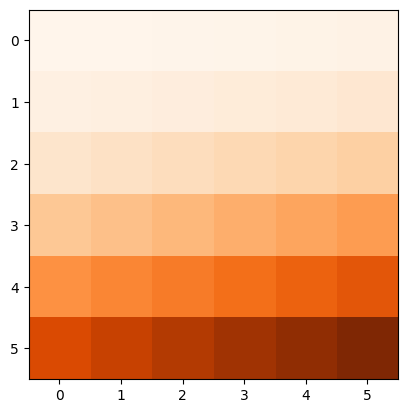

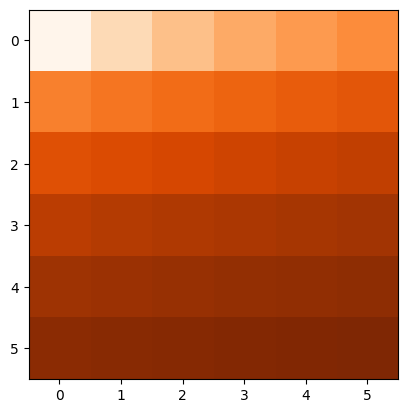

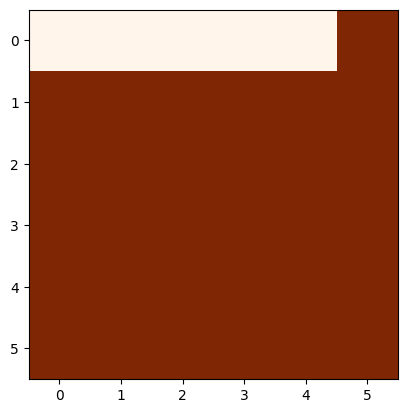

In [65]:
# Examples of different local raster operations
rasterio.plot.show(elev + elev, cmap='Oranges');
rasterio.plot.show(elev.astype(int)**2, cmap='Oranges');
rasterio.plot.show(np.log(elev), cmap='Oranges');
rasterio.plot.show(elev > 5, cmap='Oranges');

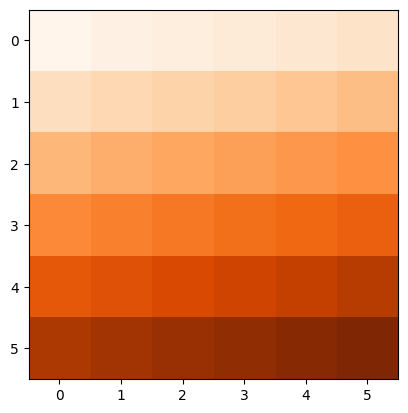

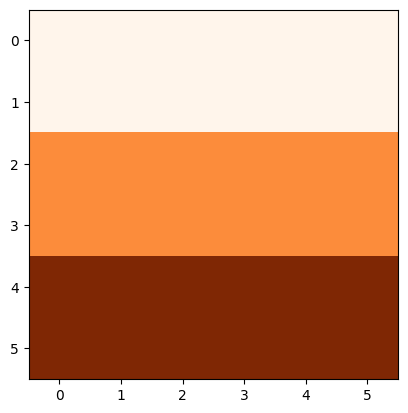

<Axes: >

In [66]:
# Another good example of local operations is the classification of intervals of numeric values into groups
# such as grouping a DEM into low, medium and high elevations. Here the raster values in different ranges are reclassified to take 
# values 1, 2 and 3 respectively
recl = elev.copy()
recl[(elev > 0) & (elev <= 12)] = 1
recl[(elev > 12) & (elev <= 24)] = 2
recl[(elev > 24) & (elev <= 36)] = 3

# Reclassifying a continous raster into three(3) categories
rasterio.plot.show(elev, cmap="Oranges")
rasterio.plot.show(recl, cmap="Oranges")

In [67]:
# The calculation of NDVI is a well-known local (pixel-by-pixel) raster operation. It returns a raster with values btw -1&1
# Vegetation absorbs light heavily in the visible light spectrum, and especially in the red channel, while reflecting NIR light
# Let's calculate NDVI for the multispectral Landsat satellite file (landsat.tif)
landsat = src_landsat.read()
nir = landsat[3]
red = landsat[2]
ndvi = (nir-red)/(nir+red)

C:\Users\install\AppData\Local\Temp\ipykernel_8812\3320713409.py:7: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir-red)/(nir+red)


In [68]:
# When plotting an RGB img using the rasterio.plot.show, the function assumes that values are in the range [0,1] for floats, 
# or [0,255] for integers (otherwise clipped) and the order of bands is RGB.
# To “prepare” the multi-band raster for rasterio.plot.show, we therefore reverse the order of the first three bands 
# (to go from B-G-R-NIR to R-G-B), using the [:3] slice to select the first three bands and then the [::-1] slice to 
# reverse the bands order, and divide by the raster maximum to set the maximum value to 1
landsat_rgb = landsat[:3][::-1] / landsat.max()

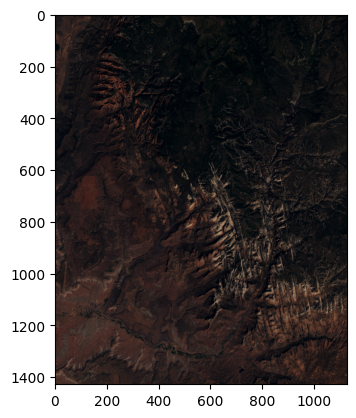

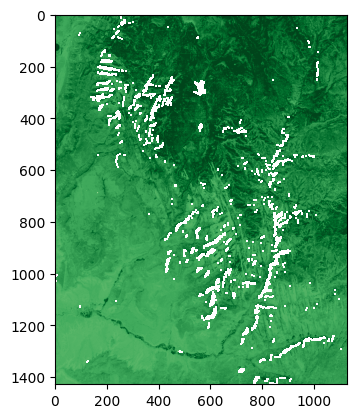

<Axes: >

In [69]:
# Display the RGB image and the NDVI calculated for the Landsat satellite image of the Zion National Park
rasterio.plot.show(landsat_rgb, cmap='RdYlGn')
rasterio.plot.show(ndvi, cmap='Greens')

##### Focal operations
Focal operations take into account a central (focal) cell and its neighbors. The neighborhood (also named kernel, filter, moving window)
under consideration is typically of 3x3 cells (that is, the central cell and its eight surrounding neighbors), but can take on any other (not necessarily rectangular) shape as defined by the user. A focal opreation applies an aggregation function to all cells within the specified neighborhood
Other names for this operation are spatial filtering and convolution

In [70]:
# here we apply the minimum filter with window size of 3. we now have a new array elev_min, 
# where each value is the minimum in the corresponding 3 x 3 neighborhood in elev
elev_min = scipy.ndimage.minimum_filter(elev, size=3)
elev_min

array([[ 1,  1,  2,  3,  4,  5],
       [ 1,  1,  2,  3,  4,  5],
       [ 7,  7,  8,  9, 10, 11],
       [13, 13, 14, 15, 16, 17],
       [19, 19, 20, 21, 22, 23],
       [25, 25, 26, 27, 28, 29]], dtype=uint8)

In [71]:
# The edges of the filtered array can be assigned with np.nan, in a number of rows and columns according to filter size.
elev_min = elev_min.astype(float)
elev_min[:, [0, -1]] = np.nan
elev_min[[0, -1], :] = np.nan
elev_min

array([[nan, nan, nan, nan, nan, nan],
       [nan,  1.,  2.,  3.,  4., nan],
       [nan,  7.,  8.,  9., 10., nan],
       [nan, 13., 14., 15., 16., nan],
       [nan, 19., 20., 21., 22., nan],
       [nan, nan, nan, nan, nan, nan]])

In [72]:
# Focal functions or filters play an important role in image processing
# For example, low-pass/smoothing filters use the mean func to remove extremes
# High pass filters often created with custom neighborhood weights often accentuate features 
# In the case of categorical data, we can replace the mean with the mode
# To demonstrate applying a mode filter, let’s read the small sample categorical raster grain.tif.
grain = src_grain.read(1)
grain

array([[1, 0, 1, 2, 2, 2],
       [0, 2, 0, 0, 2, 1],
       [0, 2, 2, 0, 0, 2],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1],
       [2, 1, 2, 2, 0, 2]], dtype=uint8)

In [73]:
# There is no built-in filter function for a mode filter in scipy.ndimage but we can use the scipy.ndimage.generic_filter
# function along with a custom filtering function, internally utilizing scipy.stats.mode
grain_mode = scipy.ndimage.generic_filter(
    grain, 
    lambda x: scipy.stats.mode(x.flatten())[0], 
    size=3
)
grain_mode = grain_mode.astype(float)
grain_mode[:, [0, -1]] = np.nan
grain_mode[[0, -1], :] = np.nan
grain_mode

array([[nan, nan, nan, nan, nan, nan],
       [nan,  0.,  0.,  0.,  2., nan],
       [nan,  0.,  0.,  0.,  1., nan],
       [nan,  1.,  1.,  1.,  1., nan],
       [nan,  1.,  1.,  1.,  1., nan],
       [nan, nan, nan, nan, nan, nan]])

In [80]:
# Calculate slope using gdaldem
os.system('gdaldem slope output/srtm_32612.tif output/srtm_32612_slope.tif')

1

In [82]:
# Replacing the metric name, we can calculate other terrain properties
# For example, here is how we can calculate an aspect raster also in degrees
os.system('gdaldem aspect output/srtm_32612.tif output/srtm_32612_aspect.tif')

1

RasterioIOError: output/srtm_32612_slope.tif: No such file or directory

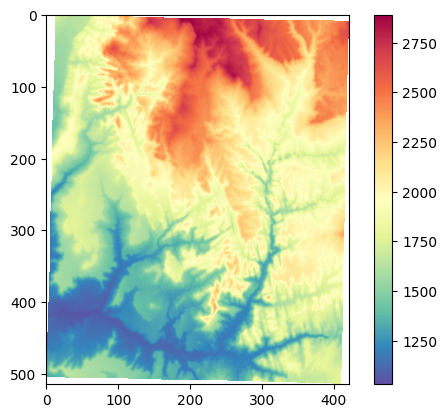

In [83]:
# Input DEM
src_srtm = rasterio.open('output/srtm_32612.tif')
srtm = src_srtm.read(1).astype(float)
srtm[srtm == src_srtm.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, cmap='Spectral_r', ax=ax)
fig.colorbar(ax.imshow(srtm, cmap='Spectral_r'), ax=ax);
# Slope
src_srtm_slope = rasterio.open('output/srtm_32612_slope.tif')
srtm_slope = src_srtm_slope.read(1)
srtm_slope[srtm_slope == src_srtm_slope.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm_slope, cmap='Spectral_r', ax=ax)
fig.colorbar(ax.imshow(srtm_slope, cmap='Spectral_r'), ax=ax);
# Aspect
src_srtm_aspect = rasterio.open('output/srtm_32612_aspect.tif')
srtm_aspect = src_srtm_aspect.read(1)
srtm_aspect[srtm_aspect == src_srtm_aspect.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm_aspect, cmap='twilight', ax=ax)
fig.colorbar(ax.imshow(srtm_aspect, cmap='twilight'), ax=ax);